# Overview

In the [submitted version of the paper](https://arxiv.org/abs/1802.06860v1) we assert: 
 > almost all of the cooling in the
1D simulation occurs in the dense shell, powered by the small
amount of thermal energy that is leaking out of the bubble
interior.

But we haven't actually proven this. It was suggested that maybe a significant portion of the cooling comes from the shock propagation. As new material is affected by the shock, some kinetic energy will turn into thermal energy.  If that converted energy is instantly radiated, would that explain a significant fraction of the cooling at any given point?

In this notebook I look into that possibility, **and find that shock propagation explains a majority of the cooling in the 1D simulation**.  I'll first write a simple first-order model of the kinetic -> thermal energy transfer rate.  I'll then apply it to every point in time for my 1D simulation.  I'll then compare it to the actual cooling rate of the simulation at each point in time.  Then we'll plot them both to compare.

# Analytic Theory, 1st order

**Assumptions**:

1. We have a 3-zone system: a hot bubble interior, a cold thin dense shell, the unaffected ISM.

    i. Hot bubble interior: Fixed mass, except during addition of SN ejecta mass. No cooling; expands adiabatically. The energy lost during expansion goes into kinetic energy of the shell
   
    ii. Dense shell: Contains _all_ of the swept up mass. Infinitely good at cooling down to a low-tempurate low-pressure equilibrium.
    
    iii. Unaffected ISM: Static and uniform density. At its equilibrium temperature (~160 K).
    
2. The shell sweeping up new material can be treated as an inelastic collision. Radial momentum is conserved and energy is conserved, but some kinetic energy will be converted into thermal energy.

Before adding a differential amount of mass, $dm$ to the shell, we have the following conservative variables: 

$$ \mathbf{U}_0 = \pmatrix{M_0 \\ M_0 V_0 \\E_{\mathrm{int}, 0} + \frac{M_0 V_0^2 }{ 2} }$$

Similarly, after the collision we have the following conservatives:

$$ \mathbf{U}_1 =  \pmatrix{M_1 \\ M_1 V_1 \\E_{\mathrm{int}, 1} + \frac{M_1 V_1^2 }{ 2} }$$

Which are related by the amount of conservatives advected in with $dm$:

$$ \Delta\mathbf{U} = \mathbf{U}_1 - \mathbf{U}_0 =  \pmatrix{dm \\ 0 \\  e_{\mathrm{int, ISM}} dm}$$

(where $e_{\mathrm{int, ISM}}$ is the specific internal energy of the ISM)>

This allows us to solve:

$$M_1 = M_0 + dm$$

so

$$ V_1 = \frac{M_0}{M_1} V_0 =  \frac{M_0}{M_0 + dm} V_0 $$

More complicated will be finding:

$ \Delta E_{\mathrm{int}} = E_{\mathrm{int},1} - E_{\mathrm{int}, 0}$

$ \Delta E_{\mathrm{int}} = \frac{M_0 V_0^2}{2} - \frac{M_1 V_1^2}{2} + e_{\mathrm{int, ISM}} dm $

$ \Delta E_{\mathrm{int}} = \frac{M_0 V_0^2}{2} - \frac{M_0^2 V_0^2}{2 M_1 } + e_{\mathrm{int, ISM}} dm $


$ \Delta E_{\mathrm{int}} = \frac{M_0 V_0^2}{2}\left(1  - \frac{M_0}{M_1 } \right) + e_{\mathrm{int, ISM}} dm $

$ \Delta E_{\mathrm{int}} = \frac{M_0 V_0^2}{2}\left( \frac{M_0 + dm  -  M_0}{M_0 + dm}\right) + e_{\mathrm{int, ISM}} dm $

$ \Delta E_{\mathrm{int}} = \frac{M_0 V_0^2}{2}dm \left( \frac{1}{M_0 + dm}\right) + e_{\mathrm{int, ISM}} dm $

Keeping only the lowest-order contribution (i.e. dropping the $dm$ in the denominator of the first term) we have: 

$ \Delta E_{\mathrm{int}} \approx \left( \frac{V_0^2}{2} + e_{\mathrm{int, ISM}} \right) dm $

We know the ISM is uniform we can express $dm$ in terms of $dt$:

$ \Delta E_{\mathrm{int}} \left( \frac{V_0^2}{2} + e_{\mathrm{int, ISM}} \right) 4 \pi R_\mathrm{shock}^2 v_\mathrm{shock} \rho_\mathrm{ISM} dt $

Now, if we assume all of that change in internal energy is radiated instantaneously, we have:


$ \dot{E}_\mathrm{cool; shock} = 4 \pi R_\mathrm{shock}^2 V_0 \rho_\mathrm{ISM} \left( \frac{V_0^2}{2}+  e_{\mathrm{int, ISM}} \right) $


Fantastic. Now this isn't enough to predict the shock energy far into the future (since the shock is also being accelerated and thus gaining kinetic energy), but at any given moment in time I think this should be okay.


# Apply shock cooling model to simulation


In [1]:
%matplotlib inline
import matplotlib as mpl

from matplotlib import pyplot as plt
import seaborn as sns; sns.set(context="poster", style="ticks")

import numpy as np

from visualize_helpers import RunSummary
from units import M_solar, m_proton, pc, yr, Myr, km, s, gamma

`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 1.0 M_solar
    length : 1.0 pc
    time   : 1.0 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'
`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 8.41e-58 M_solar
    length : 3.24e-19 pc
    time   : 3.17e-14 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'


In [20]:
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (5,3)

In [2]:
data_dir_1D = "1D_data/"

run_summary = RunSummary(data_dir_1D, "F5509BF1-3F9E-4008-B795-0482ECED199B")

run_summary.df.head()

Radius        dR            dV       Density      Pressure  Velocity  \
k i                                                                           
0 0  1.316726  0.626294  2.404438e+56  5.726431e-23  2.772651e-06       0.0   
  1  1.943019  0.626294  6.218104e+56  2.224587e-24  5.187139e-14       0.0   
  2  2.569313  0.626294  1.184572e+57  2.224587e-24  5.187139e-14       0.0   
  3  3.195607  0.626294  1.928729e+57  2.224587e-24  5.187139e-14       0.0   
  4  3.821900  0.626294  2.854280e+57  2.224587e-24  5.187139e-14       0.0   

            Z      Mass      M_int   Temperature        Energy    Entropy  \
k i                                                                         
0 0  0.952283  6.924323   6.924323  3.486347e+08  7.262773e+16  73.863802   
  1  0.020000  0.695644   7.619967  1.678950e+02  3.497596e+10  55.292614   
  2  0.020000  1.325228   8.945196  1.678950e+02  3.497596e+10  55.292614   
  3  0.020000  2.157746  11.102942  1.678950e+02  3.497596e+10  55.292614   
  4  0.020000  3.193198  14.296140  1.678950e+02  3.497596e+10  55.292614   

             C_ad  Crossing_time  zones  
k i                                      
0 0  2.840730e+08   6.802969e+09      0  
  1  1.971349e+05   9.803133e+12      1  
  2  1.971349e+05   9.803133e+12      2  
  3  1.971349e+05   9.803133e+12      3  
  4  1.971349e+05   9.803133e+12      4

In [3]:
def shock_cooling_model(run_summary):
    """Calculate 1st order model for luminosity due to shocking new material
    
    Inputs
    ------
    run_summary - instance of RunSummary
         
    Returns
    -------
    E_dot_cool_shock - np.ndarray
        dtype: float
        shape: len(run_summary.times)
    """
    
    # skip 1st checkpoint to give us the same length as V_shock below
    R_shock = run_summary.R_shock[1:]
    
    V_shock = np.diff(run_summary.R_shock) / np.diff(run_summary.times)

    rho_ISM = run_summary.overview.background_density
    e_int_ISM = run_summary.df.iloc[-1].Energy
    
    
    
    E_dot_cool_shock = 4 * np.pi * R_shock**2 * V_shock * rho_ISM \
                         * (.5*V_shock**2  + e_int_ISM)
        
    E_dot_cool_shock = 4 * np.pi * R_shock**2 * V_shock * rho_ISM \
                         * (.5*V_shock**2)
        
    # pad E_dot_cool_shock so that it's length matches `run_summary.times` again
    # (E_dot_cool = 0 at the start anyway, since V_shock = 0 at that time)
    E_dot_cool_shock = np.concatenate([
        np.array([0]),
        E_dot_cool_shock
    ])
    
    return E_dot_cool_shock
    
    

In [4]:
E_dot_cool_shock = shock_cooling_model(run_summary)

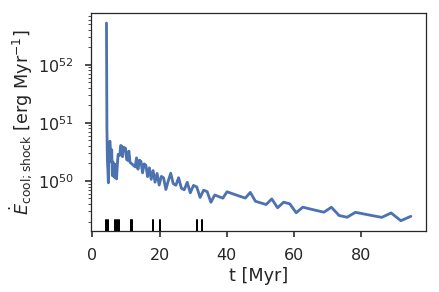

In [5]:
# skip the 1st entry because 0 looks ugly on a log scale
plt.plot(run_summary.times[1:] / Myr, 
         E_dot_cool_shock[1:] * Myr)

plt.yscale("log")


plt.xlabel("t [Myr]")
plt.ylabel("$\dot{E}_\mathrm{cool; shock}$ [erg Myr$^{-1}$]")

sns.rugplot(run_summary.overview.SNe_times / Myr, 
            color="k",
            linewidth=2)

# Cooling Rate Calculated by Grackle

In [6]:
from visualize_helpers import grackle_temperature_1D, grackle_cooling_rate_1D

E_dot_cool_grackle = np.zeros_like(run_summary.times)

for k in range(len(E_dot_cool_grackle)):
    df_tmp  = run_summary.df.loc[k]
    E_dot_cool_grackle[k] = grackle_cooling_rate_1D(df_tmp).sum()


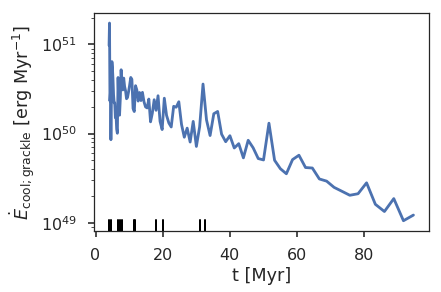

In [7]:
plt.plot(run_summary.times / Myr,
         E_dot_cool_grackle * Myr,
         )

plt.yscale("log")

plt.xlabel("t [Myr]")
plt.ylabel("$\dot{E}_\mathrm{cool; grackle}$ [erg Myr$^{-1}$]")

sns.rugplot(run_summary.overview.SNe_times / Myr, 
            color="k",
            linewidth=2)

# Plot Both

Text(0.5,1,'1D, Lagrangian')

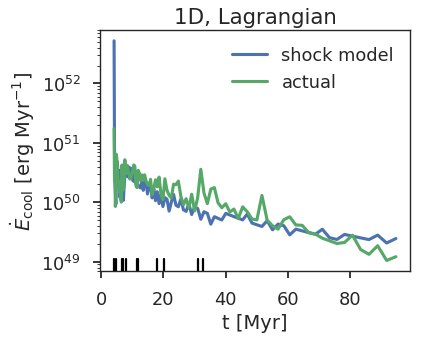

In [18]:
plt.plot(run_summary.times[1:] / Myr,
         E_dot_cool_shock[1:] * Myr,
         label="shock model"
         )

plt.plot(run_summary.times[1:] / Myr,
         E_dot_cool_grackle[1:] * Myr,
         label="actual"
         )

plt.yscale("log")

plt.xlabel("t [Myr]")
plt.ylabel("$\dot{E}_\mathrm{cool}$ [erg Myr$^{-1}$]")

sns.rugplot(run_summary.overview.SNe_times / Myr, 
            color="k",
            linewidth=2)

plt.legend(loc="best")

plt.title("1D, Lagrangian")

Text(0.5,1,'1D, Lagrangian')

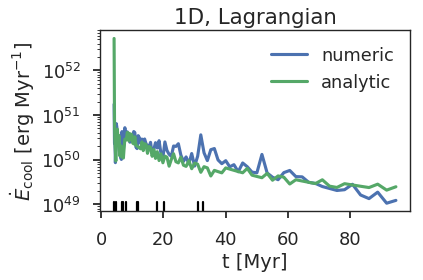

In [21]:

plt.plot(run_summary.times[1:] / Myr,
         E_dot_cool_grackle[1:] * Myr,
         label="numeric"
         )

plt.plot(run_summary.times[1:] / Myr,
         E_dot_cool_shock[1:] * Myr,
         label="analytic"
         )


plt.yscale("log")

plt.xlabel("t [Myr]")
plt.ylabel("$\dot{E}_\mathrm{cool}$ [erg Myr$^{-1}$]")

sns.rugplot(run_summary.overview.SNe_times / Myr, 
            color="k",
            linewidth=2)

plt.legend(loc="best")

plt.title("1D, Lagrangian")

So it does appear that shock propagation-related cooling is the dominant source of cooling in our Lagrangian 1D simulations.

# What about 1D Eulerian simulations?
Okay, so maybe the shock-cooling result is only a _lower-limit_ on cooling. Maybe you can still get stronger cooling, beyond what this predicts, through mixing/diffusivity.  It'd be a pain to try to test this using our 3D results, but maybe we can test it using some old 1D eulerian results.

In [9]:
data_dir_1D_euler = "/pfs/home/egentry/data/clustered_SNe/10_veryhires_euler_slow"

run_summary_euler = RunSummary(data_dir_1D_euler, "")

run_summary_euler.df.head()

Radius        dR            dV       Density      Pressure  Velocity  \
k i                                                                           
0 0  0.377286  0.156573  5.286051e+54  2.505787e-21  1.261181e-04       0.0   
  1  0.533859  0.156573  1.211569e+55  2.224587e-24  3.089513e-12       0.0   
  2  0.690432  0.156573  2.177962e+55  2.224587e-24  3.089513e-12       0.0   
  3  0.847006  0.156573  3.427785e+55  2.224587e-24  3.089513e-12       0.0   
  4  1.003579  0.156573  4.961038e+55  2.224587e-24  3.089513e-12       0.0   

            Z      Mass     M_int   Temperature        Energy    Entropy  \
k i                                                                        
0 0  0.989102  6.661243  6.661243  3.624038e+08  7.549610e+16  70.143223   
  1  0.020000  0.013554  6.674797  1.000000e+04  2.083204e+12  61.423116   
  2  0.020000  0.024366  6.699163  1.000000e+04  2.083204e+12  61.423116   
  3  0.020000  0.038348  6.737511  1.000000e+04  2.083204e+12  61.423116   
  4  0.020000  0.055501  6.793012  1.000000e+04  2.083204e+12  61.423116   

             C_ad  Crossing_time  zones  
k i                                      
0 0  2.896283e+08   1.668121e+09      0  
  1  1.521404e+06   3.175586e+11      1  
  2  1.521404e+06   3.175586e+11      2  
  3  1.521404e+06   3.175586e+11      3  
  4  1.521404e+06   3.175586e+11      4

In [10]:
E_dot_cool_shock_euler = shock_cooling_model(run_summary_euler)

# Cooling Rate Calculated by Grackle

In [11]:
E_dot_cool_grackle_euler = np.zeros_like(run_summary_euler.times)

for k in range(len(E_dot_cool_grackle_euler)):
    df_tmp  = run_summary_euler.df.loc[k]
    E_dot_cool_grackle_euler[k] = grackle_cooling_rate_1D(df_tmp).sum()


# Plot Both

Text(0.5,1,'1D, Eulerian')

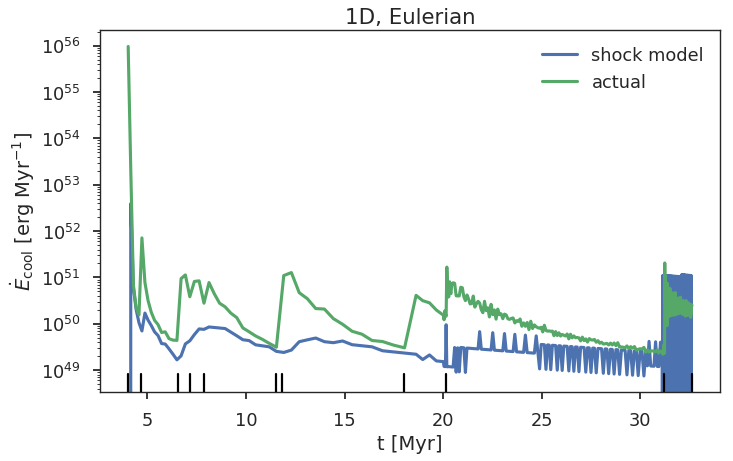

In [14]:
plt.plot(run_summary_euler.times / Myr,
         E_dot_cool_shock_euler * Myr,
         label="shock model"
         )

plt.plot(run_summary_euler.times / Myr,
         E_dot_cool_grackle_euler * Myr,
         label="actual"
         )

plt.yscale("log")

plt.xlabel("t [Myr]")
plt.ylabel("$\dot{E}_\mathrm{cool}$ [erg Myr$^{-1}$]")

sns.rugplot(run_summary_euler.overview.SNe_times / Myr, 
            color="k",
            linewidth=2)

plt.legend(loc="best")

plt.title("1D, Eulerian")